https://www.quantstart.com/articles/kalman-filter-based-pairs-trading-strategy-in-qstrader/
https://blog.quantinsti.com/kalman-filter-techniques-statistical-arbitrage-china-futures-market-python/
https://www.quantconnect.com/forum/discussion/6826/from-research-to-production-kalman-filters-and-pairs-trading/p1


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

DATA_PATH = '/mnt/d/Working/PersonalProjects/Trading/trading-agent/crypto-pair-trading/data/crypto/1h'

symbols = ['DOT-USDT', 'DOGE-USDT']

data = []

for symbol in symbols:
    try:
        file = f'{DATA_PATH}/{symbol}.csv'
        df = pd.read_csv(file, 
                        parse_dates=['open_time'], 
                        index_col=['open_time'])
        # df = df[df.index < end_date].copy()
        df = df[~df.index.duplicated(keep='first')]

        df.rename(columns={'close': symbol}, inplace=True)
        # the data is too long, just limit to recent period
        data.append(np.log(df[symbol]))
    except:
        pass

df = pd.concat(data, axis=1)
df = df.dropna(axis=1, how='all')
df.dropna(inplace=True, how='any')

df.head()

,DOT-USDT,DOGE-USDT
open_time,,
2020-08-22 07:00:00,1.230517,-5.685746
2020-08-22 08:00:00,1.348073,-5.685157
2020-08-22 09:00:00,1.362770,-5.688401
2020-08-22 10:00:00,1.339989,-5.691953
2020-08-22 11:00:00,1.343126,-5.696112


In [2]:
print(df[symbols[0]].shape, df[symbols[1]].shape)

(14925,) (14925,)


In [3]:
static_hedge = [ 10.45820267, -12.20189966]
spread = static_hedge[0] * df[symbols[0]] + static_hedge[1] * df[symbols[1]]
spread_mean = spread.mean()
spread_upper = spread.mean() + 2 * spread.std()
spread_lower = spread.mean() - 2 * spread.std()

sdf = pd.DataFrame(dict(
    spread=spread,
    mean=spread_mean,
    upper=spread_upper,
    lower=spread_lower
))

<AxesSubplot:xlabel='open_time'>

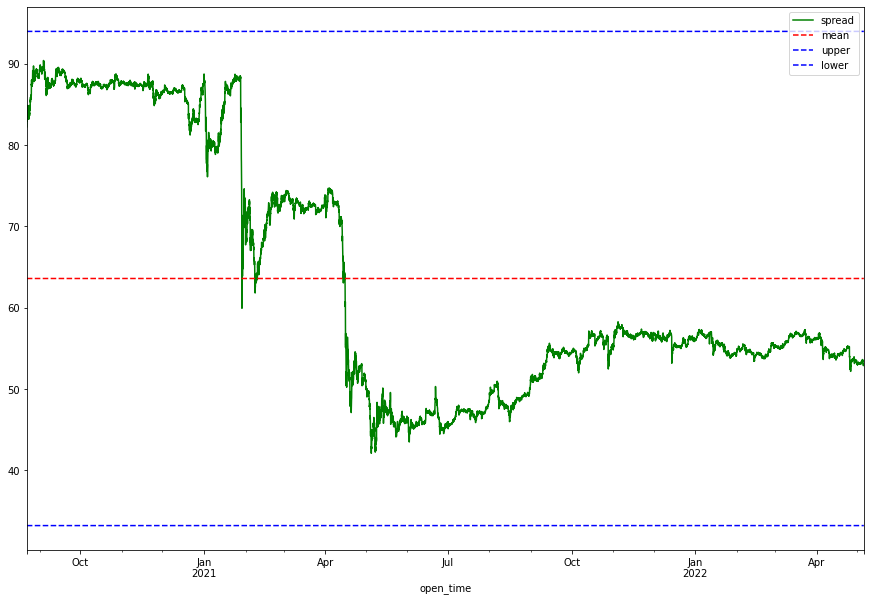

In [4]:
sdf.plot(figsize =(15,10), style=['g', '--r', '--b', '--b'])

In [5]:
def update(price1, price2):
    delta = 1e-5
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.vstack(
        [price1, np.ones(price1.shape)]
    ).T[:, np.newaxis]

    kf = KalmanFilter(
        n_dim_obs=1, 
        n_dim_state=2,
        initial_state_mean=np.zeros(2),
        initial_state_covariance=np.ones((2, 2)),
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        observation_covariance=1.0,
        transition_covariance=trans_cov
    )

    state_means, state_covs = kf.filter(price2.values)
    return state_means, state_covs

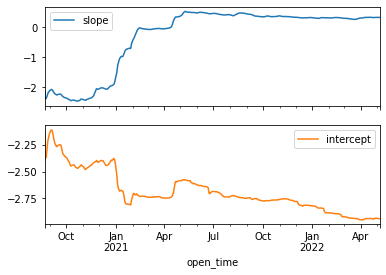

In [6]:
state_means, state_covs = update(df[symbols[0]], df[symbols[1]])

pd.DataFrame(
    dict(
        slope=state_means[:, 0], 
        intercept=state_means[:, 1]
    ), index=df.index
).plot(subplots=True)

plt.show()

<AxesSubplot:xlabel='open_time'>

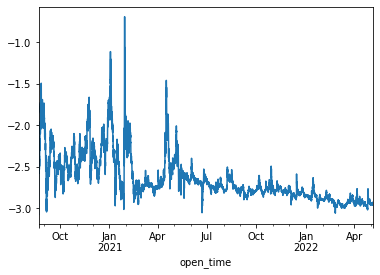

In [7]:
kl_spread = df[symbols[1]] - df[symbols[0]] * state_means[:,0]
kl_spread.plot()


In [8]:
def calculate_kalman_filter(series):
    _df = df[(df.index >= series.index[0]) & (df.index <= series.index[-1])].copy()
    p1 = _df[symbols[0]]
    p2 = _df[symbols[1]]

    state_means, state_covs = update(p1, p2)
    kl_spread = p2 - p1 * state_means[:,0] - state_means[:,1]
    return kl_spread.iloc[-1]

rolling_spread = df[symbols[0]].rolling(200).apply(calculate_kalman_filter)

<AxesSubplot:xlabel='open_time'>

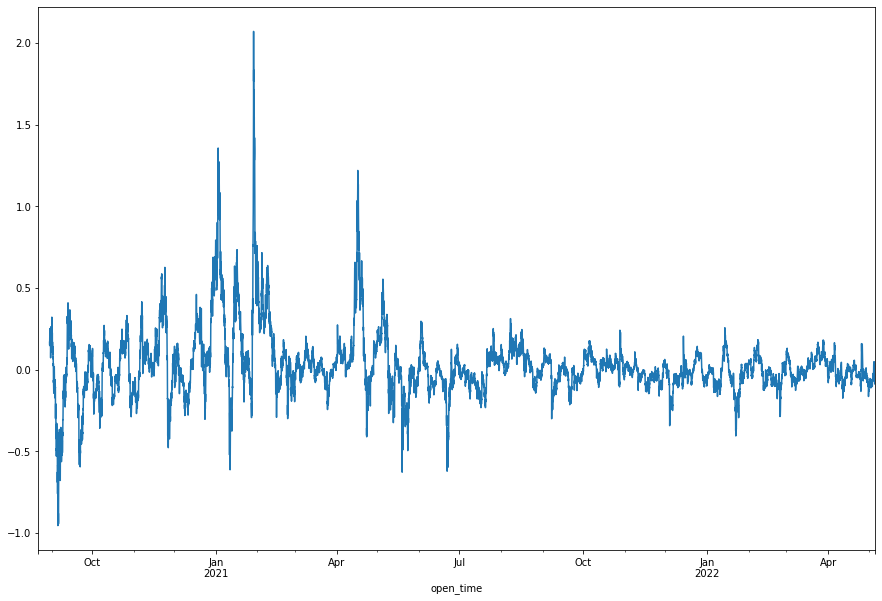

In [9]:
rolling_spread.plot(figsize =(15,10))

In [10]:
cal_upper = lambda spread: spread.mean() + 2 * spread.std()
cal_lower = lambda spread: spread.mean() - 2 * spread.std()

rm_mean = rolling_spread.rolling(200).mean()
rm_upper = rolling_spread.rolling(200).apply(cal_upper)
rm_lower = rolling_spread.rolling(200).apply(cal_lower)

_rm = pd.DataFrame(dict(
    spread=rolling_spread,
    mean=rm_mean,
    upper=rm_upper,
    lower=rm_lower
), index=rolling_spread.index)


<AxesSubplot:xlabel='open_time'>

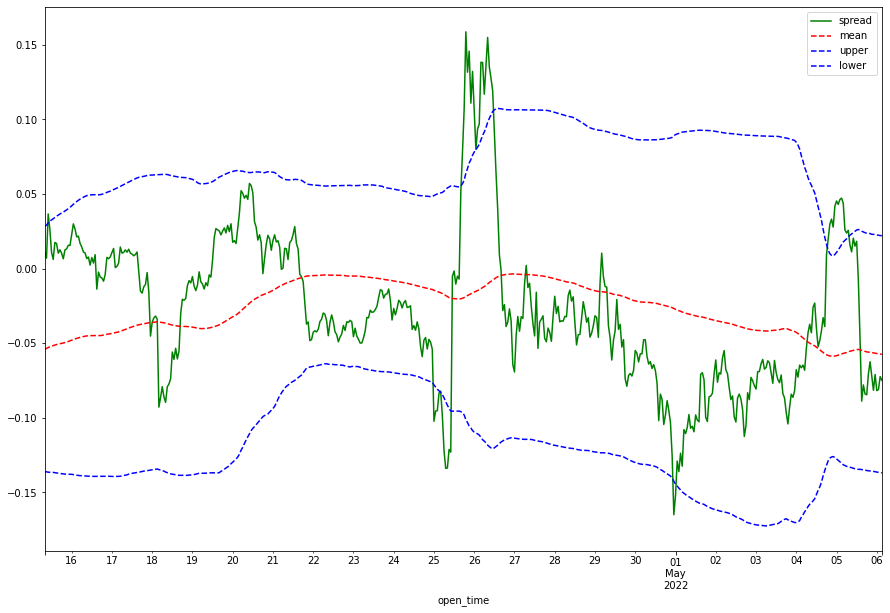

In [11]:
_rm.iloc[-500:].plot(figsize =(15,10), style=['g', '--r', '--b', '--b'])